In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.transforms as T
import torchvision.datasets as dset

from torch.utils.data import DataLoader, sampler, Dataset
from pytorch_load_data import load_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

plt.ion()   # interactive mode

In [2]:
dataloaders, poster_train, poster_val, poster_test = load_data()
print(iter(dataloaders['train']).next()[0].size())

torch.Size([1, 3, 224, 224])


tensor([ 0])


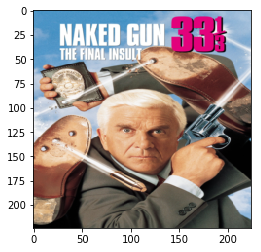

In [3]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)
# print(' '.join('%5s' % labels for j in range(BATCHSIZE)))

In [4]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available(): 
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100
print('using device:', device)

using device: cuda


In [5]:
def flatten(x):
    N = x.shape[0] #read in N, C, H, W
    return x.view(N, -1) # "flatten" the C * H * W values into a sing le vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2) 
    print('Before flattening: ', x) 
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[  0.,   1.],
          [  2.,   3.],
          [  4.,   5.]]],


        [[[  6.,   7.],
          [  8.,   9.],
          [ 10.,  11.]]]])
After flattening:  tensor([[  0.,   1.,   2.,   3.,   4.,   5.],
        [  6.,   7.,   8.,   9.,  10.,  11.]])


In [6]:
class Flatten(nn.Module):
    def forward(self, x): 
        return flatten(x)

In [7]:
def check_accuracy(loader, model): 
    if loader.dataset.train:
        print('Checking accuracy on validation set') 
    else:
        print('Checking accuracy on test set')

    num_correct = 0
    num_samples = 0
    model.eval() # set model to evaluation mode 
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples , 100 * acc))

In [8]:
def train_part(model, optimizer, epochs=1): 
    """
     - model: A PyTorch Module giving the model to train.
     - optimizer: An Optimizer object we will use to train the model
     - epochs: (Optional) A Python integer giving the number of epochs to train for
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device) # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(dataloaders['train']):
            model.train() # put model to training mode
            x = x.to(device=device, dtype=dtype) # move to device, e.
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            main_loss.append(loss)
            
            # Zero out all of the gradients for the variables which th
            # will update.
            
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the
            # respect to each  parameter of the model.
            loss.backward()
            
            # Actually update the parameters of the model using the gr
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %s' % (e))
                print('Iteration %d, loss = %.4f' % (t, loss.item())) 
                check_accuracy(dataloaders['val'], model)
                print()

In [9]:
channel_1 = 32
channel_2 = 16
channel_3 = 32
channel_4 = 16
learning_rate = .01
in_channel = 3
num_classes = 2
num_features = 3*32*32

main_loss = []

model = nn.Sequential(
#Layer 1
    nn.Conv2d(in_channel, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.BatchNorm2d(channel_1),
#Layer2
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(channel_2),
    #Layer2.2 ====> added in as an experiment
    nn.Conv2d(channel_2, channel_3, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.BatchNorm2d(channel_3),
#Layer3
    nn.Conv2d(channel_3, channel_4, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.BatchNorm2d(channel_4),
#Layer4
    Flatten(),
    nn.Linear((802816), num_classes)
)

# optimizer = optim.Adam(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_part(model, optimizer, epochs=5)

Epoch: 0
Iteration 0, loss = 0.9870
Checking accuracy on validation set
Got 493 / 954 correct (51.68)

Epoch: 0
Iteration 100, loss = 128.0361
Checking accuracy on validation set
Got 476 / 954 correct (49.90)

Epoch: 0
Iteration 200, loss = 0.0000
Checking accuracy on validation set
Got 487 / 954 correct (51.05)

Epoch: 0
Iteration 300, loss = 0.0000
Checking accuracy on validation set
Got 467 / 954 correct (48.95)

Epoch: 0
Iteration 400, loss = 0.0000
Checking accuracy on validation set
Got 486 / 954 correct (50.94)

Epoch: 0
Iteration 500, loss = 2.4828
Checking accuracy on validation set
Got 476 / 954 correct (49.90)

Epoch: 0
Iteration 600, loss = 0.0000
Checking accuracy on validation set
Got 478 / 954 correct (50.10)

Epoch: 0
Iteration 700, loss = 20.7514
Checking accuracy on validation set
Got 488 / 954 correct (51.15)

Epoch: 0
Iteration 800, loss = 57.7807
Checking accuracy on validation set
Got 504 / 954 correct (52.83)

Epoch: 0
Iteration 900, loss = 0.0000
Checking accura

KeyboardInterrupt: 